In [1]:
# This is the notebook for honours project analysis on galaxy cluster XLSSC 122
# This notebook will serve as sort of a journal of what is done on the project
# Proceeds chronologically with updated TODOs:

# Notebook part 2: image analysis 
# First we load in the necessary modules:

# Standard libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import warnings
import cv2

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from matplotlib.patches import Ellipse, Circle


# astro specific
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft

import FITS_tools
from matplotlib import rc

from matplotlib import rc

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'


In [2]:
# DATA:

# Now need to load in the data files for the fits image as well as the catalogues:

# fits:

fits_path ="/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/IVM_xlssuj0217-0345-f140w_drz_sci.fits"
xlssc_fits = fits.open(fits_path)

# extracted fits:

extract_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits"
extract_fits = fits.open(extract_path)

# x-ray image:

xray_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits"
xray_fits = fits.open(xray_path)

# smoothed x-ray image:

smooth_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits"
smooth_fits = fits.open(smooth_path)

# catalogue files:

# shape of short file: 12 X 1374

# id ra dec (F105) kron ekron 0p8 e0p8 (F140) kron ekron 0p8 e0p8 fwhm (asec) 

cat_sh_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_short.cat"
cat_sh = np.loadtxt(cat_sh_path)

# shape of long file: 22 X 1301

# phot-id ra dec (f105) kron ekron 0p8 e0p8 (f140) kron ekron 0p8 e0p8 fwhm (asec) zz zlo zhi chi spec-id mcode snr em-code member1 member2

cat_lo_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat"
cat_lo = np.loadtxt(cat_lo_path)

data_path = "/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/extended_data_table.csv"
member_data = np.loadtxt(data_path, dtype='str',delimiter=',', skiprows=1).T

# # cleans up the data:
# member_data[0][0] = '526'
# member_data = member_data.T
# # removes zero column
# member_data = np.delete(member_data, 6, 0)

# Splits into interesting quantities:

mem_ID = np.array(member_data[0], dtype=float); mem_RA = np.array(member_data[1], dtype=float);
mem_DEC = np.array(member_data[2], dtype=float); mem_mag = np.array(member_data[3], dtype=float);
mem_col = np.array(member_data[4], dtype=float); mem_z = np.array(member_data[5], dtype=float);
mem_notes = np.array(member_data[6], dtype=str)

# creates masks for each member group:

gold_mask = np.array([0.0 for i in range(len(mem_ID))])
silver_mask = np.array([0.0 for i in range(len(mem_ID))])
fg_mask = np.array([0.0 for i in range(len(mem_ID))])
e_mask = np.array([0.0 for i in range(len(mem_ID))])

for i in range(len(mem_notes)):
    note = mem_notes[i]
    
    if (note == 'G' or note =='GE'):
        gold_mask[i] = 1
        silver_mask[i] = float("nan")
        fg_mask[i] = float("nan")
        if note == 'GE':
            e_mask[i] = 1
    elif (note == 'SE' or note == 'S'):
        gold_mask[i] = float("nan")
        silver_mask[i] = 1
        fg_mask[i] = float("nan")
        if note == 'SE':
            e_mask[i] = 1
    elif (note == 'F'):
        gold_mask[i] = float("nan")
        silver_mask[i] = float("nan")
        fg_mask[i] = 1
        
# for the next task it will be nice to have the RA and DEC for the 
# gold, silver and foreground galaxies:

gold_RA = mem_RA * gold_mask; gold_DEC = mem_DEC * gold_mask;
silver_RA = mem_RA * silver_mask; silver_DEC = mem_DEC * silver_mask;
fg_RA = mem_RA * fg_mask; fg_DEC = mem_DEC * fg_mask;

In [3]:
print(extract_path)

/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits


In [4]:
with fits.open(xray_path) as xray_fits:
    xray_fits.info()
with fits.open(smooth_path) as smooth_fits:
    smooth_fits.info()
with fits.open(extract_path) as extract_fits:
    extract_fits.info()    

    
xlssc_hdu = fits.open(fits_path)[0]
xlssc_wcs = WCS(xlssc_hdu.header)    
extract_hdu = fits.open(extract_path)[0]
extract_wcs = WCS(extract_hdu.header)
xray_hdu = fits.open(xray_path)[0]
xray_wcs = WCS(xray_hdu.header)
xray_smooth_hdu = fits.open(smooth_path)[0]
xray_smooth_wcs = WCS(xray_smooth_hdu.header)
xlssc_image = fits.getdata(fits_path, ext=0)
extract_image = fits.getdata(extract_path, ext=0)
xray_image = fits.getdata(xray_path, ext=0)
xray_smooth = fits.getdata(smooth_path, ext=0)


Filename: /Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/image400-3000_comb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     476   (900, 900)   float32   
Filename: /Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/asmooth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     431   (241, 241)   float64   
Filename: /Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Data.nosync/xlssuj0217-0345-f140w_drz_seg_spec_extract.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1197   (4313, 4312)   int32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 57219.298958 from DATE-OBS.
Set MJD-END to 57220.498646 from DATE-END'. [astropy.wcs.wcs]


In [5]:
xlssc_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 34.43489663592974  -3.759438963401738  
CRPIX : 2156.75301585793  2157.945983957825  
CD1_1 CD1_2  : -1.6666666666666e-05  -3.4020032180935e-22  
CD2_1 CD2_2  : 4.98381001766088e-22  1.66666666666666e-05  
NAXIS : 4313  4312

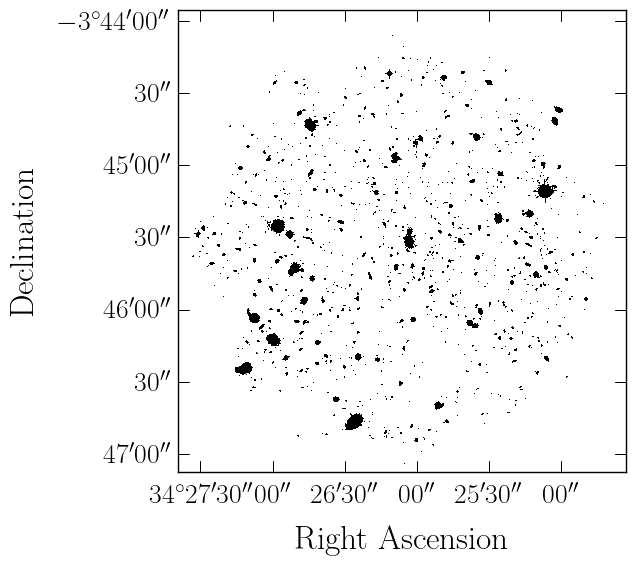

In [6]:

ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(extract_image,vmin=0.004, vmax =0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(8,6)

plt.show()

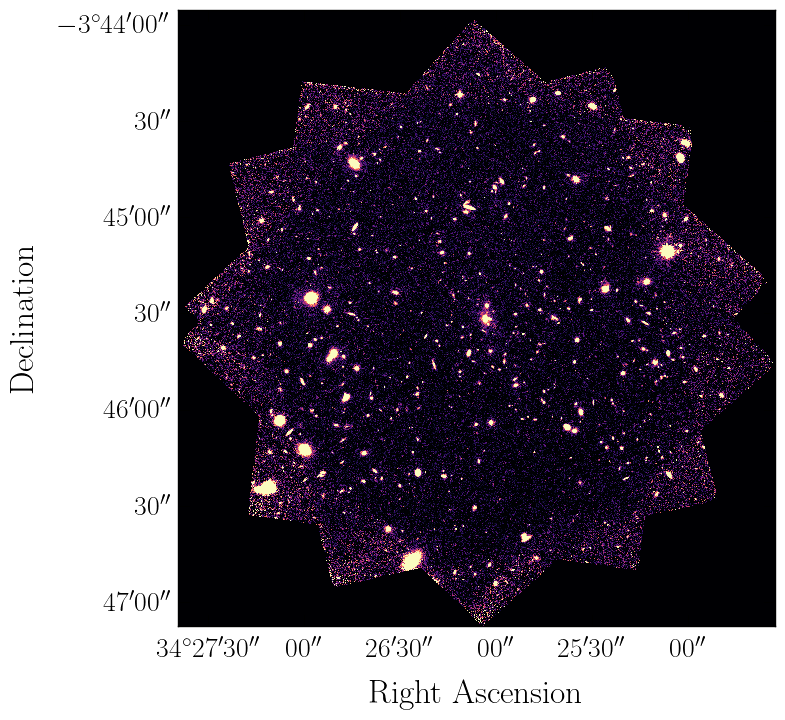

In [7]:
# we can now try to plot the fits file:

# plots the figure:
width=10
height=8
ax1=plt.subplot(projection=xlssc_wcs)

ff = plt.gcf()
ff.set_figwidth(width)
ff.set_figheight(height)

ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_hdu.data,vmin=0.0003,vmax=0.04,cmap='magma', interpolation='none')
# restricts image to just range of interest:

xmin = 600; xmax = 3700;
ymin = 600; ymax = 3800;


ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

ax1.invert_yaxis()
plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/XA_xlssc_1222_append", dpi=250)


In [8]:
# Finds the min and max values for the above image used and converts them
# to the xray coordinate system in pixels:

min_coords= xlssc_wcs.pixel_to_world(ymin,xmin)
max_coords= xlssc_wcs.pixel_to_world(ymax,xmax)

min_extract = extract_wcs.world_to_pixel(min_coords)
max_extract = extract_wcs.world_to_pixel(max_coords)

min_xray = xray_wcs.world_to_pixel(min_coords)
max_xray = xray_wcs.world_to_pixel(max_coords)

min_smooth = xray_smooth_wcs.world_to_pixel(min_coords)
max_smooth = xray_smooth_wcs.world_to_pixel(max_coords)

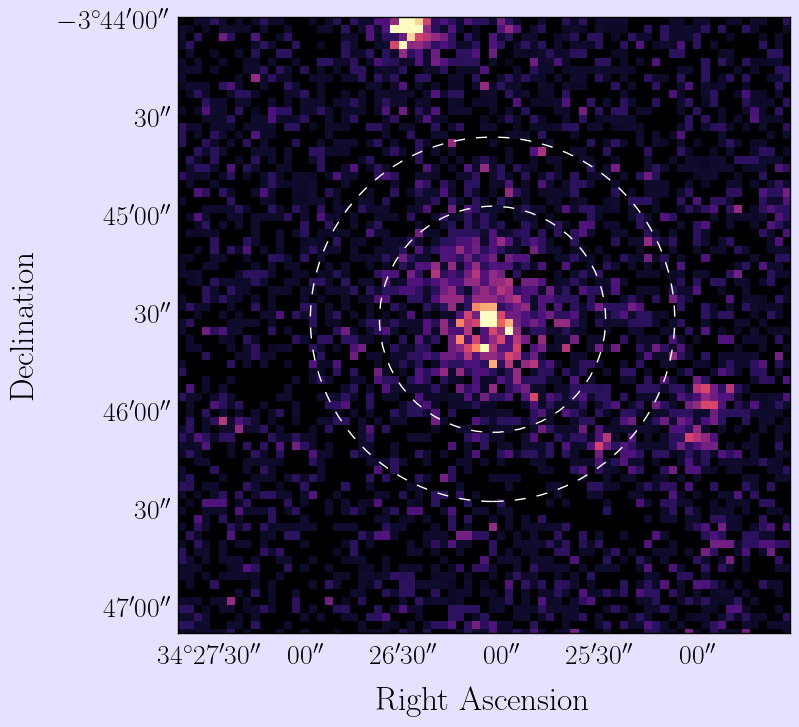

In [34]:
#warnings.filterwarnings('ignore')

# plots the figure:
width=10
height=8
ax1=plt.subplot(projection=xray_wcs)

ff=plt.gcf()
ff.set_figwidth(width)
ff.set_figheight(height)

ax1=plt.subplot(projection=xray_wcs)
ax1.imshow(xray_hdu.data,vmin=0,vmax=12,cmap='magma', interpolation='none')
# restricts image to just range of interest:
#ax1.set_xlim(0,1000)
ax1.set_ylim(min_xray[1], max_xray[1]+1)
ax1.set_xlim(min_xray[0], max_xray[0]-2)


#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
#ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)
RA_TARG =   3.443412500000E+01
DEC_TARG=  -3.758738888889E+00 
centre = SkyCoord(RA_TARG,DEC_TARG,unit=u.deg)
pix_centre = xray_wcs.world_to_pixel(centre)
pix_centre = (pix_centre[0], pix_centre[1])
circ_200 = plt.Circle(pix_centre,22.3,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_200)    
circ_500 = plt.Circle(pix_centre,13.84,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_500) 
#ax1.invert_yaxis()
plt.tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False)
plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, right=False)

ff.set_facecolor('#e6e1fe')
#ff.tight_layout(pad=-3.0)
#ax1.set_aspect('equal')  # Or specify the aspect ratio manually

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/499_xray_intro", dpi=250)#,bbox_inches='tight')


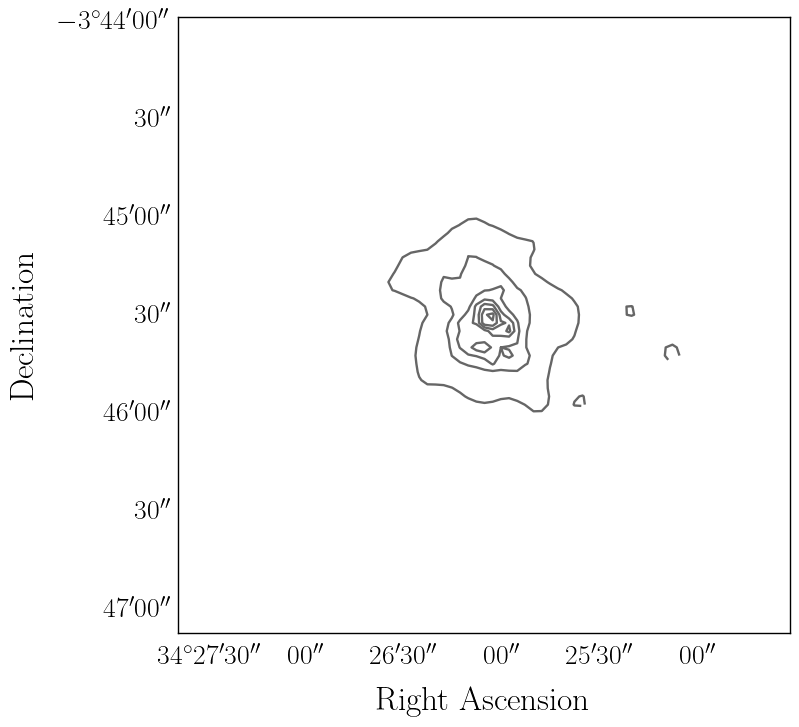

In [39]:
warnings.filterwarnings('ignore')

# plots the figure:
width=10
height=8
ax1=plt.subplot(projection=xray_smooth_wcs)

ff=plt.gcf()
ff.set_figwidth(width)
ff.set_figheight(height)

#ax1=plt.subplot(projection=xray_wcs)
ax1.contour(xray_smooth_hdu.data,vmin=0,vmax=0.5,levels=8,cmap='Dark2', interpolation='linear',alpha=1)
#CP = ax1.contour(XX, ZZ, pc_mag_field, levels=E_lines,linewidths=1,cmap="magma",norm=PowerNorm(0.07))
ax1.imshow(xlssc_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')

# restricts image to just range of interest:
#ax1.set_xlim(0,1000)
ax1.set_xlim(min_smooth[0], max_smooth[0]-2)
ax1.set_ylim(min_smooth[1], max_smooth[1]+1)


#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
#ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)
RA_TARG =   3.443412500000E+01
DEC_TARG=  -3.758738888889E+00 
centre = SkyCoord(RA_TARG,DEC_TARG,unit=u.deg)
pix_centre = xray_smooth_wcs.world_to_pixel(centre)
pix_centre = (pix_centre[0], pix_centre[1])
circ_200 = plt.Circle(pix_centre,22.3,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_200)    
circ_500 = plt.Circle(pix_centre,13.84,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_500) 
#ax1.invert_yaxis()
plt.tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False)
plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, right=False)

#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/1_xray_intro", dpi=250)


In [ ]:
ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_hdu.data,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension', fontsize=24)
lat.set_axislabel('Declination', fontsize=24)
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,8)

# converts into pixel coordinates:

# first gold:

pix_coords_gold = [[] for i in range(len(gold_RA))]
for i in range(len(gold_RA)):
    coord = SkyCoord(gold_RA[i],gold_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_gold[i] = pixels
    
mem_pix_gold = np.array(pix_coords_gold).T   

# adds circles:
for i in range(len(mem_pix_gold[1])):
    if math.isnan(mem_pix_gold[0][i])==False:
        centre = (mem_pix_gold[0][i],mem_pix_gold[1][i])
        circ = plt.Circle( centre,50,fill = False,color='red')
        ax1.add_patch(circ)
    else:
        pass

# then silver:

pix_coords_sil = [[] for i in range(len(silver_RA))]
for i in range(len(silver_RA)):
    coord = SkyCoord(silver_RA[i],silver_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_sil[i] = pixels
    
mem_pix_sil = np.array(pix_coords_sil).T   

# adds circles:
for i in range(len(mem_pix_sil[1])):
    if math.isnan(mem_pix_sil[0][i])==False:
        centre = (mem_pix_sil[0][i],mem_pix_sil[1][i])
        circ = plt.Circle( centre,50,fill = False,color='g')
        ax1.add_patch(circ)
    else:
        pass
    
# and for foreground:

pix_coords_fg = [[] for i in range(len(fg_RA))]
for i in range(len(fg_RA)):
    coord = SkyCoord(fg_RA[i],fg_DEC[i],unit=u.deg)
    pixels = xlssc_wcs.world_to_pixel(coord)
    pix_coords_fg[i] = pixels
    
mem_pix_fg = np.array(pix_coords_fg).T

for i in range(len(mem_pix_fg[1])):
    if math.isnan(mem_pix_fg[0][i])==False:
        centre = (mem_pix_fg[0][i],mem_pix_fg[1][i])
        circ = plt.Circle( centre,50,fill = False,color='navy')
        ax1.add_patch(circ)
    else:
        pass

# adds a circle at the centre:

centre = SkyCoord(RA_TARG,DEC_TARG,unit=u.deg)
pix_centre = xlssc_wcs.world_to_pixel(centre)



pix_centre = (pix_centre[0]-50, pix_centre[1])
circ_200 = plt.Circle(pix_centre,880,fill = False,color='k', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_200)    
circ_500 = plt.Circle(pix_centre,560,fill = False,color='k', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_500) 
ax1.grid(False)
    

plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/1_members_intro", dpi=250)

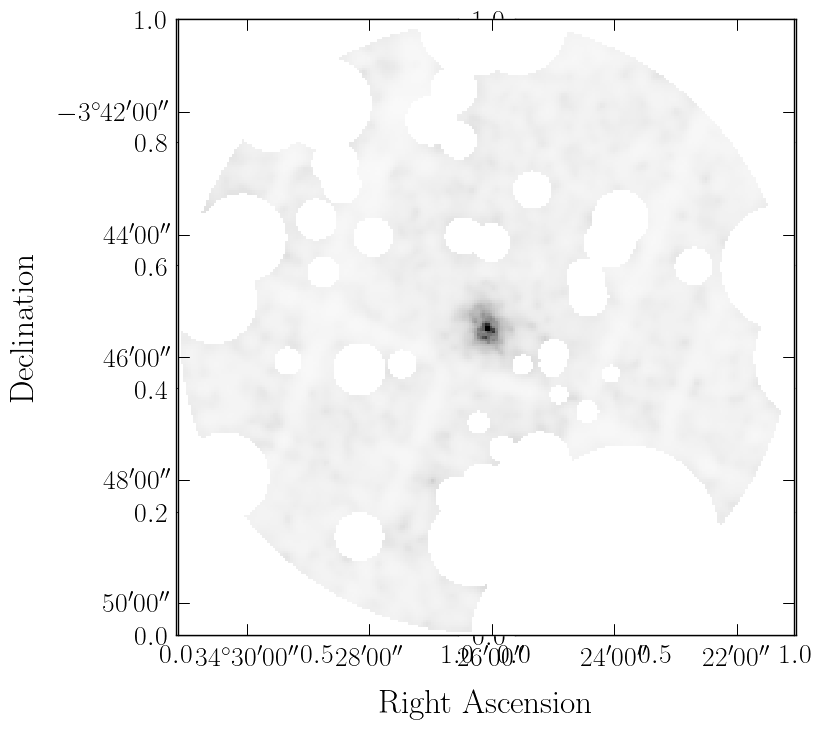

In [48]:
warnings.filterwarnings('ignore')

# plots the figure:
width=8
height=8
ff, (ax1) = plt.subplots(1,2);ff.set_figwidth(width);ff.set_figheight(height)

ax1=plt.subplot(projection=xray_smooth_wcs)
ax1.imshow(xray_smooth_hdu.data,vmin=0.040,vmax=10,cmap='gray_r', interpolation='none')

#ax1.set_xlim(min_smooth[0], max_smooth[0])
#ax1.set_ylim(min_smooth[1], max_smooth[1])

ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0];lat = ax1.coords[1];lon.set_axislabel('Right Ascension');lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss');lat.set_major_formatter('dd:mm:ss');lon.set_ticks(number=6);lat.set_ticks(number=7)

ax1.invert_yaxis()
plt.show()

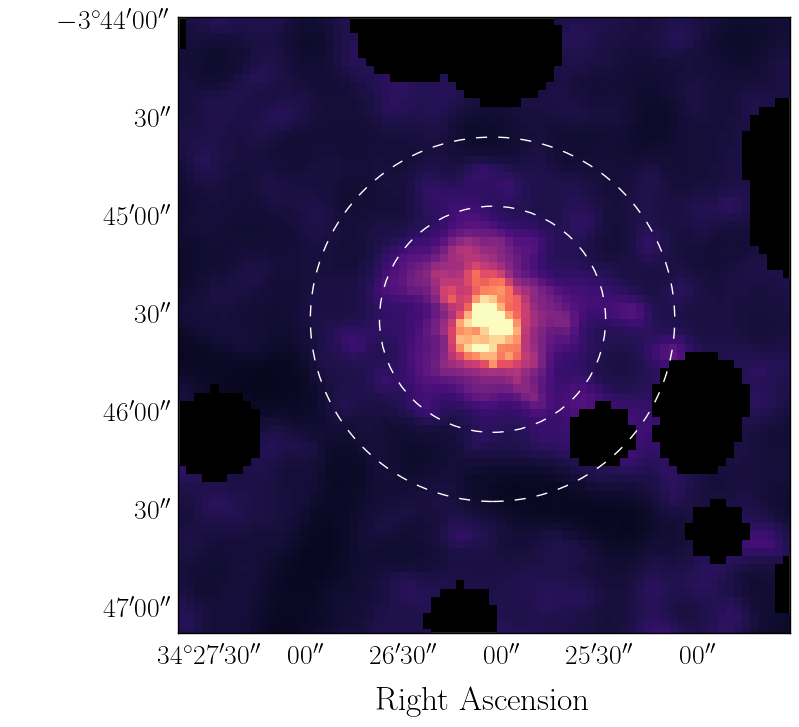

In [53]:
warnings.filterwarnings('ignore')

# plots the figure:


ax1=plt.subplot(projection=xray_smooth_wcs)


width=10;height=8;ff = plt.gcf();ff.set_figwidth(width);ff.set_figheight(height)

ax1=plt.subplot(projection=xray_smooth_wcs)
ax1.imshow(xray_smooth_hdu.data,vmin=0.02,vmax=6,cmap='magma', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(min_smooth[0], max_smooth[0]-2)
ax1.set_ylim(min_smooth[1], max_smooth[1]+1)

#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
#ax1.invert_yaxis()


# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension',fontsize=24)
lat.set_axislabel(' ',fontsize=24)
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=6)

#ax1.invert_yaxis()

RA_TARG =   3.443412500000E+01
DEC_TARG=  -3.758738888889E+00 
centre = SkyCoord(RA_TARG,DEC_TARG,unit=u.deg)
pix_centre = xray_smooth_wcs.world_to_pixel(centre)
pix_centre = (pix_centre[0], pix_centre[1])
circ_200 = plt.Circle(pix_centre,22.3,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_200)    
circ_500 = plt.Circle(pix_centre,13.84,fill = False,color='w', linestyle=(0,(8,8)), label=r'$r_{500}$')
ax1.add_patch(circ_500) 
plt.tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False)
plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, right=False)

ax1.set_facecolor('k')

warnings.filterwarnings('ignore')



plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/1_smoothed_xray_test", dpi=250)


In [41]:
from astropy.visualization.wcsaxes import WCSAxes


In [113]:
# first gold:
​
# pix_coords_gold = [[] for i in range(len(gold_RA))]
# for i in range(len(gold_RA)):
#     coord = SkyCoord(gold_RA[i],gold_DEC[i],unit=u.deg)
#     pixels = xray_smooth_wcs.world_to_pixel(coord)
#     pix_coords_gold[i] = pixels
    
# mem_pix_gold = np.array(pix_coords_gold).T   
​
# # adds circles:
# for i in range(len(mem_pix_gold[1])):
#     if math.isnan(mem_pix_gold[0][i])==False:
#         centre = (mem_pix_gold[0][i],mem_pix_gold[1][i])
#         circ = plt.Circle( centre,1.2,fill = False,color='r')
#         ax1.add_patch(circ)
#     else:
#         pass
​
# # then silver:
​
# pix_coords_sil = [[] for i in range(len(silver_RA))]
# for i in range(len(silver_RA)):
#     coord = SkyCoord(silver_RA[i],silver_DEC[i],unit=u.deg)
#     pixels = xray_smooth_wcs.world_to_pixel(coord)
#     pix_coords_sil[i] = pixels
    
# mem_pix_sil = np.array(pix_coords_sil).T   
​
# # adds circles:
# for i in range(len(mem_pix_sil[1])):
#     if math.isnan(mem_pix_sil[0][i])==False:
#         centre = (mem_pix_sil[0][i],mem_pix_sil[1][i])
#         circ = plt.Circle( centre,1.2,fill = False,color='lawngreen')
#         ax1.add_patch(circ)
#     else:
#         pass
    
# # and for foreground:
​
# pix_coords_fg = [[] for i in range(len(fg_RA))]
# for i in range(len(fg_RA)):
#     coord = SkyCoord(fg_RA[i],fg_DEC[i],unit=u.deg)
#     pixels = xray_smooth_wcs.world_to_pixel(coord)
#     pix_coords_fg[i] = pixels
    
# mem_pix_fg = np.array(pix_coords_fg).T
​
# for i in range(len(mem_pix_fg[1])):
#     if math.isnan(mem_pix_fg[0][i])==False:
#         centre = (mem_pix_fg[0][i],mem_pix_fg[1][i])
#         circ = plt.Circle( centre,1.2,fill = False,color='b')
#         ax1.add_patch(circ)
#     else:
#         pass
​

SyntaxError: invalid non-printable character U+200B (1090496487.py, line 2)

In [114]:
arcmin_to_kpc = 8.530 # kpc/"
degree_to_kpc = arcmin_to_kpc * 3600 # kpc/degree

# centre of xray image is:
xray_cdelt = xray_wcs.wcs.cdelt

In [115]:
xray_cdelt*degree_to_kpc

array([-21.325,  21.325])

In [116]:
443/(xray_cdelt*degree_to_kpc)

array([-20.77373974,  20.77373974])

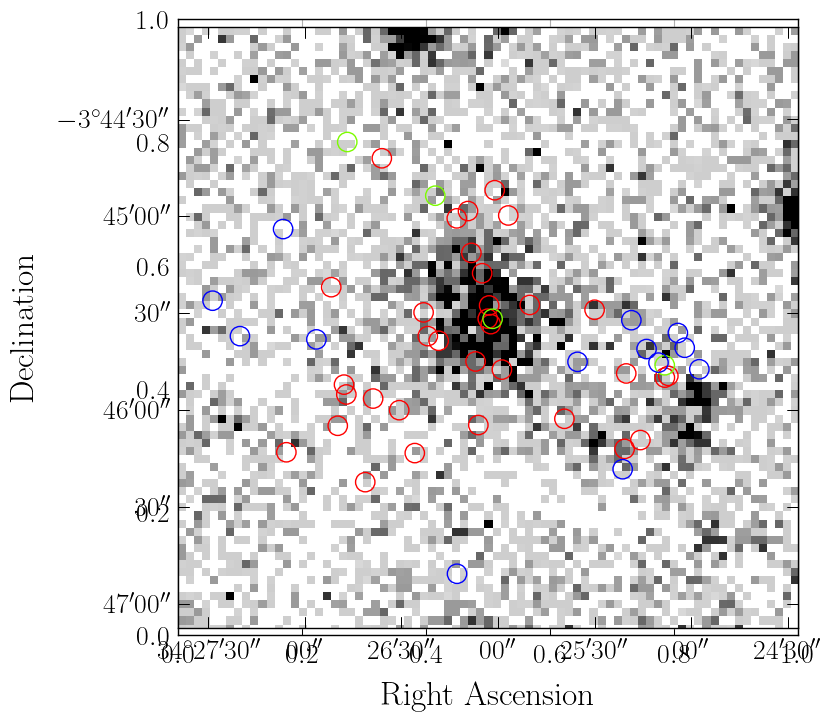

In [117]:
warnings.filterwarnings('ignore')

# plots the figure:
width=8;height=8;ff, (ax1) = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height)

ax1=plt.subplot(projection=xray_wcs)
ax1.imshow(xray_image,vmin=0.040,vmax=5,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(min_xray[0], max_xray[0])
ax1.set_ylim(min_xray[1], max_xray[1])

#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
ax1.invert_yaxis()

# first gold:

pix_coords_gold = [[] for i in range(len(gold_RA))]
for i in range(len(gold_RA)):
    coord = SkyCoord(gold_RA[i],gold_DEC[i],unit=u.deg)
    pixels = xray_wcs.world_to_pixel(coord)
    pix_coords_gold[i] = pixels
    
mem_pix_gold = np.array(pix_coords_gold).T   

# adds circles:
for i in range(len(mem_pix_gold[1])):
    if math.isnan(mem_pix_gold[0][i])==False:
        centre = (mem_pix_gold[0][i],mem_pix_gold[1][i])
        circ = plt.Circle( centre,1.2,fill = False,color='r')
        ax1.add_patch(circ)
    else:
        pass

# then silver:

pix_coords_sil = [[] for i in range(len(silver_RA))]
for i in range(len(silver_RA)):
    coord = SkyCoord(silver_RA[i],silver_DEC[i],unit=u.deg)
    pixels = xray_wcs.world_to_pixel(coord)
    pix_coords_sil[i] = pixels
    
mem_pix_sil = np.array(pix_coords_sil).T   

# adds circles:
for i in range(len(mem_pix_sil[1])):
    if math.isnan(mem_pix_sil[0][i])==False:
        centre = (mem_pix_sil[0][i],mem_pix_sil[1][i])
        circ = plt.Circle( centre,1.2,fill = False,color='lawngreen')
        ax1.add_patch(circ)
    else:
        pass
    
# and for foreground:

pix_coords_fg = [[] for i in range(len(fg_RA))]
for i in range(len(fg_RA)):
    coord = SkyCoord(fg_RA[i],fg_DEC[i],unit=u.deg)
    pixels = xray_wcs.world_to_pixel(coord)
    pix_coords_fg[i] = pixels
    
mem_pix_fg = np.array(pix_coords_fg).T

for i in range(len(mem_pix_fg[1])):
    if math.isnan(mem_pix_fg[0][i])==False:
        centre = (mem_pix_fg[0][i],mem_pix_fg[1][i])
        circ = plt.Circle( centre,1.2,fill = False,color='b')
        ax1.add_patch(circ)
    else:
        pass

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)


#ax1.set_xlim(34,36)

ax1.invert_yaxis()
plt.show()

In [118]:
# we now want to generate an arbitrary kernel to convolve the 
# image with:

def k_convolve(image, kernel2):
    new_image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel2)
    return new_image

def astro_convolve(image_, kernel_):
    new_image = convolve(image_, kernel_)
    return new_image

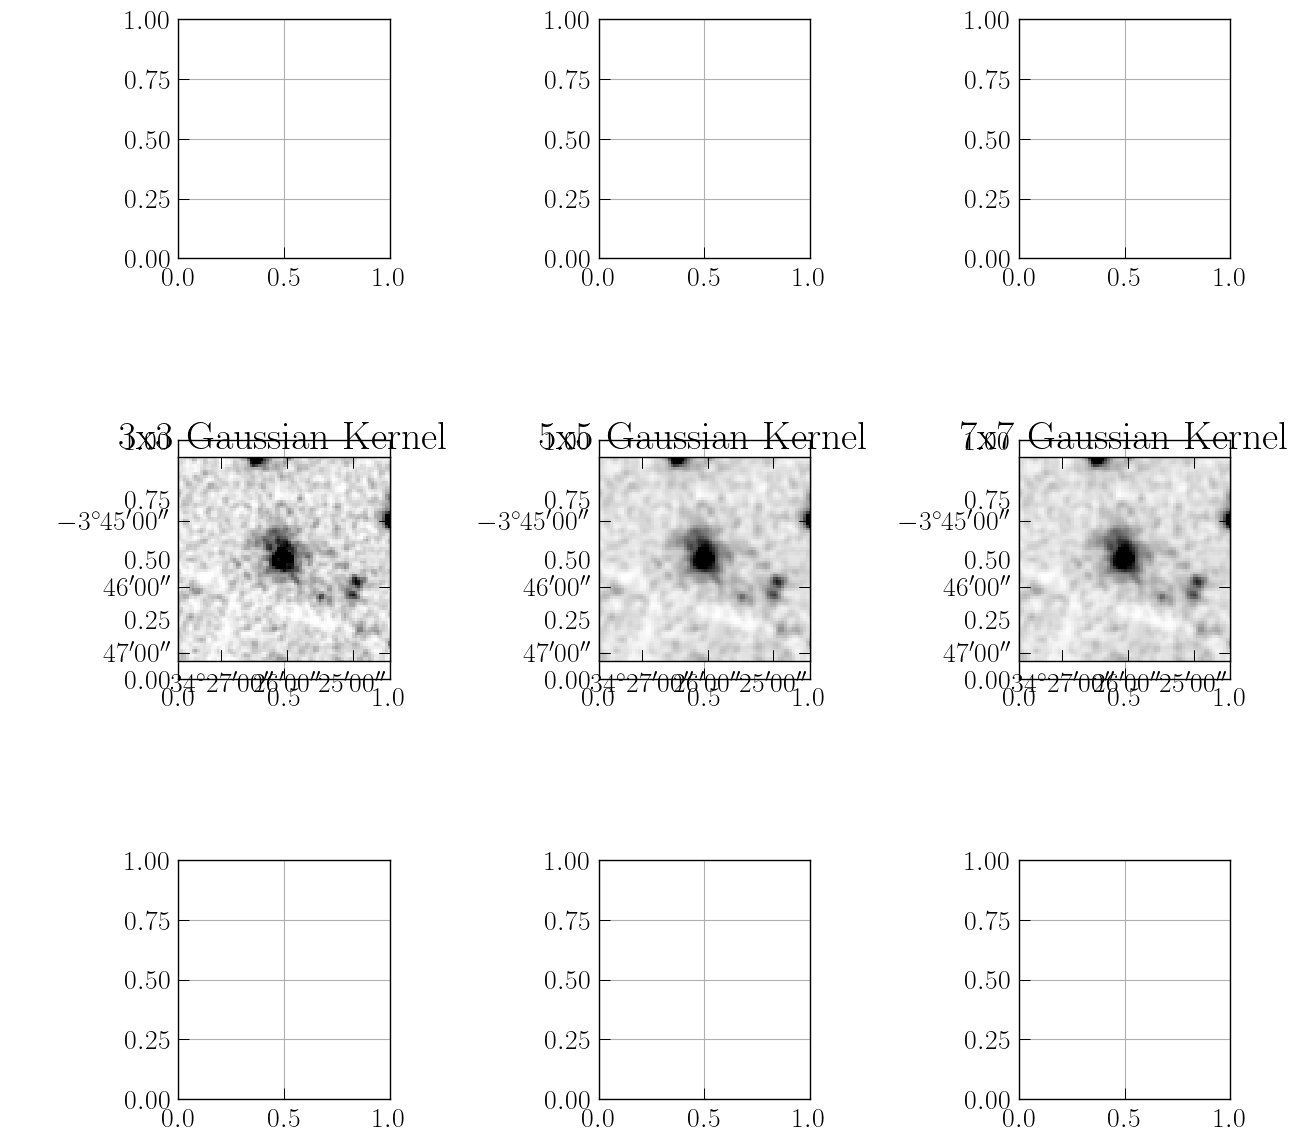

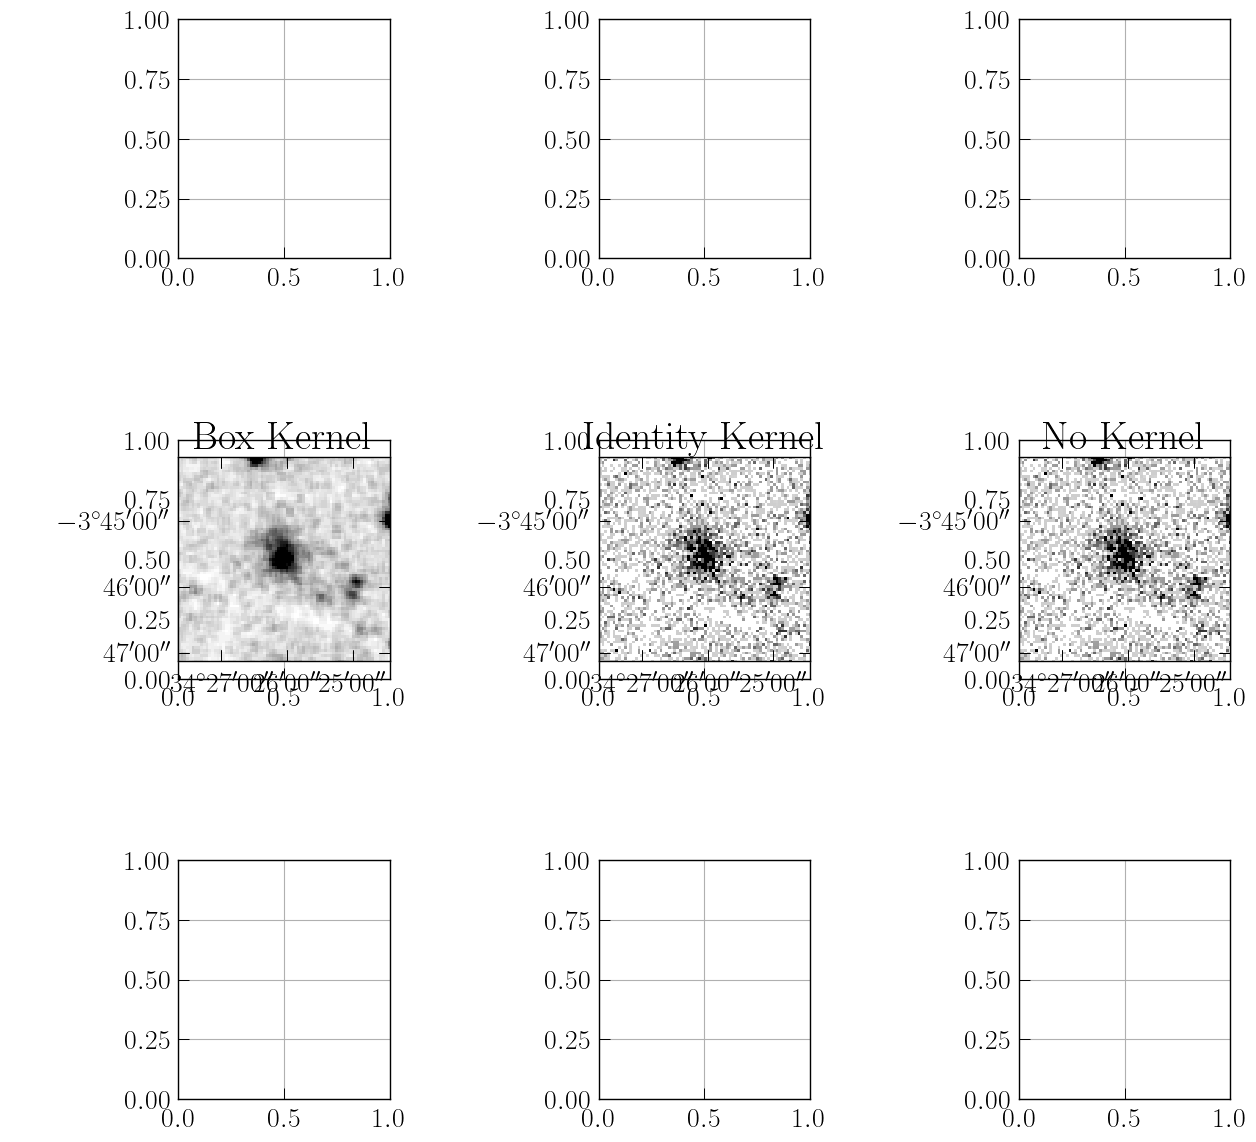

In [119]:
# using the above function, lets try to plot the above image but with
# an applied kernel:

# gaussian, box, gaussian 5x5:

gauss3_kernel = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])
gauss5_kernel = 1/256* np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])
box_kernel = 1/9* np.array([[1,1,1],[1,1,1],[1,1,1]])
identity_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
gauss7_kernel = 1/12162*np.array([
    [1, 7, 26, 41, 26, 7, 1],
    [7, 49, 184, 290, 184, 49, 7],
    [26, 184, 694, 1097, 694, 184, 26],
    [41, 290, 1097, 1738, 1097, 290, 41],
    [26, 184, 694, 1097, 694, 184, 26],
    [7, 49, 184, 290, 184, 49, 7],
    [1, 7, 26, 41, 26, 7, 1]
])

# convolved xray images:

xray_gauss3 = astro_convolve(xray_image, gauss3_kernel)
xray_gauss5 = astro_convolve(xray_image, gauss5_kernel)
xray_box = astro_convolve(xray_image, box_kernel)
xray_identity = astro_convolve(xray_image, identity_kernel)
xray_gauss7 = astro_convolve(xray_image, gauss7_kernel)


warnings.filterwarnings('ignore')

# plots the figure:
width=14;height=14;ff, (ax1,ax2,ax3) = plt.subplots(3,3);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=5.0)
ax1=plt.subplot(1,3,1,projection=xray_wcs)
ax2=plt.subplot(1,3,2,projection=xray_wcs)
ax3=plt.subplot(1,3,3,projection=xray_wcs)

ax1.imshow(xray_gauss3,vmin=0.040,vmax=5,cmap='gray_r', interpolation='none')
ax2.imshow(xray_gauss5,vmin=0.040,vmax=5,cmap='gray_r', interpolation='none')
ax3.imshow(xray_gauss7,vmin=0.040,vmax=5,cmap='gray_r', interpolation='none')


ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.set_title("3x3 Gaussian Kernel")
ax2.set_title("5x5 Gaussian Kernel")
ax3.set_title("7x7 Gaussian Kernel")
#converts the x-axis to degrees and works with the ticks:
lon1 = ax1.coords[0]
lat1 = ax1.coords[1]
lon1.set_axislabel(' ')#'Right Ascension')
lat1.set_axislabel(' ')#'Declination')
lon1.set_major_formatter('dd:mm:ss')
lat1.set_major_formatter('dd:mm:ss')
lon1.set_ticks(number=3)
lat1.set_ticks(number=4)
lon2 = ax2.coords[0]
lat2 = ax2.coords[1]
lon2.set_axislabel(' ')#'Right Ascension')
lat2.set_axislabel(' ')#'Declination')
lon2.set_major_formatter('dd:mm:ss')
lat2.set_major_formatter('dd:mm:ss')
lon2.set_ticks(number=3)
lat2.set_ticks(number=4)
lon3 = ax3.coords[0]
lat3 = ax3.coords[1]
lon3.set_axislabel(' ')#'Right Ascension')
lat3.set_axislabel(' ')#'Declination')
lon3.set_major_formatter('dd:mm:ss')
lat3.set_major_formatter('dd:mm:ss')
lon3.set_ticks(number=3)
lat3.set_ticks(number=4)
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax1.set_xlim(min_xray[0], max_xray[0])
ax1.set_ylim(min_xray[1], max_xray[1])
ax2.set_xlim(min_xray[0], max_xray[0])
ax2.set_ylim(min_xray[1], max_xray[1])
ax3.set_xlim(min_xray[0], max_xray[0])
ax3.set_ylim(min_xray[1], max_xray[1])
plt.show()
width=14;height=14;ff, (ax1,ax2,ax3) = plt.subplots(3,3);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=5.0)
ax1=plt.subplot(1,3,1,projection=xray_wcs)
ax2=plt.subplot(1,3,2,projection=xray_wcs)
ax3=plt.subplot(1,3,3,projection=xray_wcs)

ax1.imshow(xray_box,vmin=0.0,vmax=5,cmap='gray_r', interpolation='none')
ax2.imshow(xray_identity,vmin=0.040,vmax=5,cmap='gray_r', interpolation='none')
ax3.imshow(xray_image,vmin=0.04,vmax=5,cmap='gray_r', interpolation='none')


ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.set_title("Box Kernel")
ax2.set_title("Identity Kernel")
ax3.set_title("No Kernel")
#converts the x-axis to degrees and works with the ticks:
lon1 = ax1.coords[0]
lat1 = ax1.coords[1]
lon1.set_axislabel(' ')#'Right Ascension')
lat1.set_axislabel(' ')#'Declination')
lon1.set_major_formatter('dd:mm:ss')
lat1.set_major_formatter('dd:mm:ss')
lon1.set_ticks(number=3)
lat1.set_ticks(number=4)
lon2 = ax2.coords[0]
lat2 = ax2.coords[1]
lon2.set_axislabel(' ')#'Right Ascension')
lat2.set_axislabel(' ')#'Declination')
lon2.set_major_formatter('dd:mm:ss')
lat2.set_major_formatter('dd:mm:ss')
lon2.set_ticks(number=3)
lat2.set_ticks(number=4)
lon3 = ax3.coords[0]
lat3 = ax3.coords[1]
lon3.set_axislabel(' ')#'Right Ascension')
lat3.set_axislabel(' ')#'Declination')
lon3.set_major_formatter('dd:mm:ss')
lat3.set_major_formatter('dd:mm:ss')
lon3.set_ticks(number=3)
lat3.set_ticks(number=4)
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax1.set_xlim(min_xray[0], max_xray[0])
ax1.set_ylim(min_xray[1], max_xray[1])
ax2.set_xlim(min_xray[0], max_xray[0])
ax2.set_ylim(min_xray[1], max_xray[1])
ax3.set_xlim(min_xray[0], max_xray[0])
ax3.set_ylim(min_xray[1], max_xray[1])
plt.show()

In [120]:
###### still need to figure this out for arbitrary input

# now we want to define functions that remove objects that we want:

extract_hdu = fits.open(extract_path)[0]

def single_mask(N,ex_image):
    '''
    Takes an object ID N and
    returns a mask for that
    particular object
    '''
    mask = ex_image
    mask[mask!=N] = 0
    mask[mask==N]= 2
    mask[mask==0]= 1
    mask[mask==2]= 0
    return mask

def vector_mask(list_masks,ex_image):
    '''
    tasks list of objects and makes a single 
    mask out of them. Returns mask sum
    '''
    sum_mask = ex_image
    for i in list_masks:
        sum_mask[sum_mask==i] = 2

    sum_mask[sum_mask!=2]= 0
    sum_mask[sum_mask==0]= 1
    sum_mask[sum_mask==2]= 0
    
    return sum_mask

In [121]:
# creates a list of non-members:

non_mem_ID = []
for i in cat_sh.T[0]:
    if i not in mem_ID:
        non_mem_ID.append(i)
nomem_mask = vector_mask(non_mem_ID,fits.open(extract_path)[0].data)

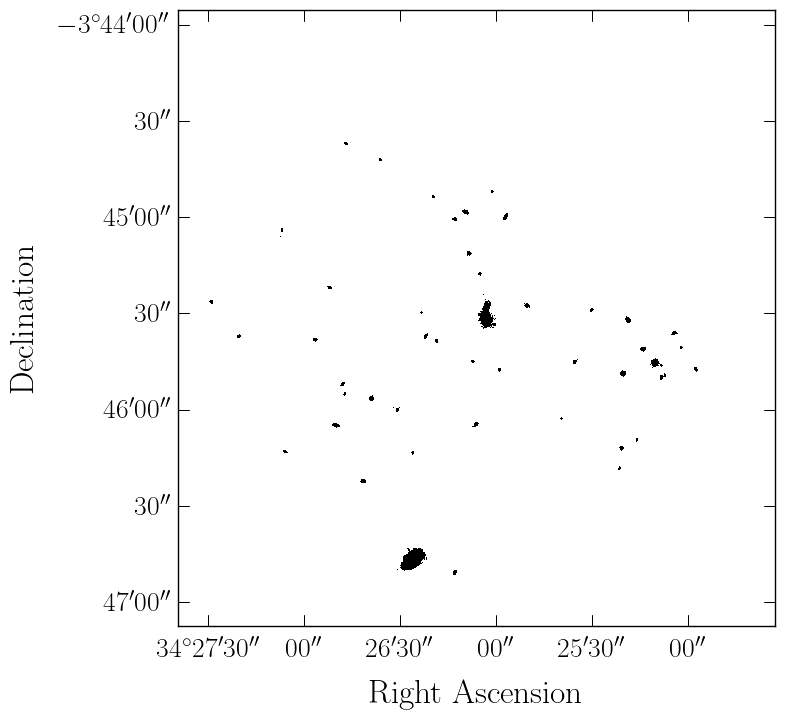

In [125]:
member_plot= vector_mask(mem_ID, fits.open(extract_path)[0].data)

ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(member_plot,vmin=0.004, vmax =0.05,cmap='gray', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,8)


#ax1.invert_yaxis()
    
#plt.savefig("/Users/benrasmussen/Desktop/Phys 499-Honours Thesis/Thesis Plots/1_segmap_members_intro", dpi=250)


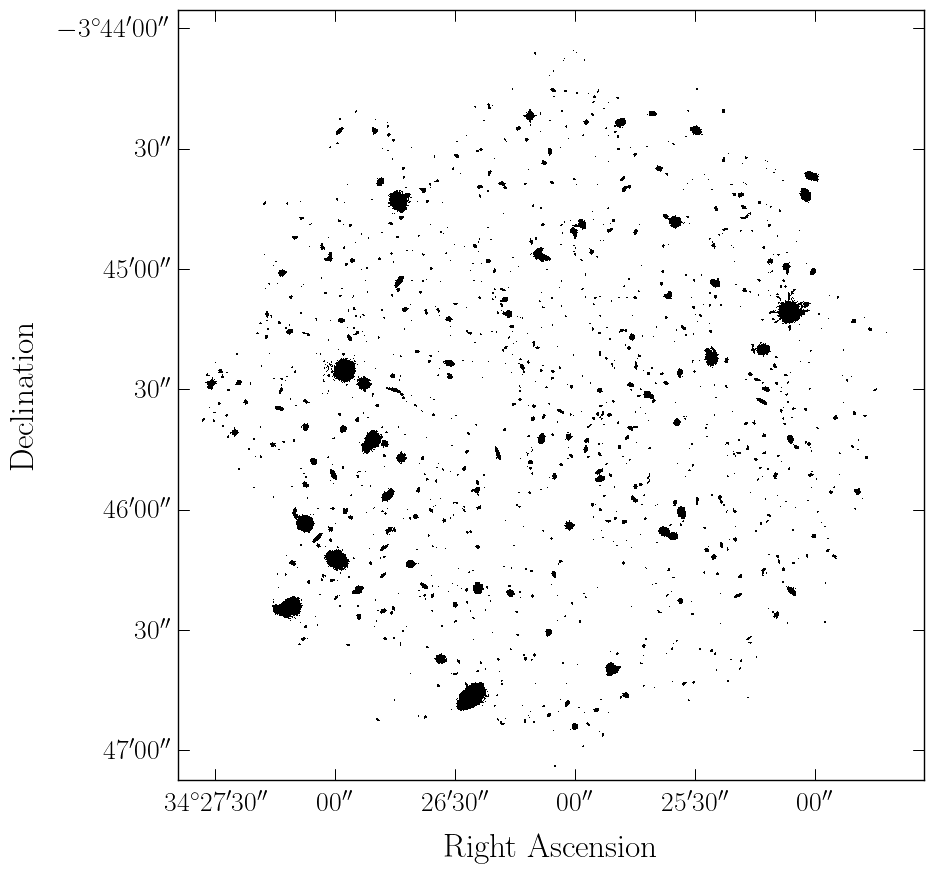

In [126]:
ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(nomem_mask,vmin=0.004, vmax =0.05,cmap='gray', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(10,10)


#ax1.invert_yaxis()
    
plt.show()

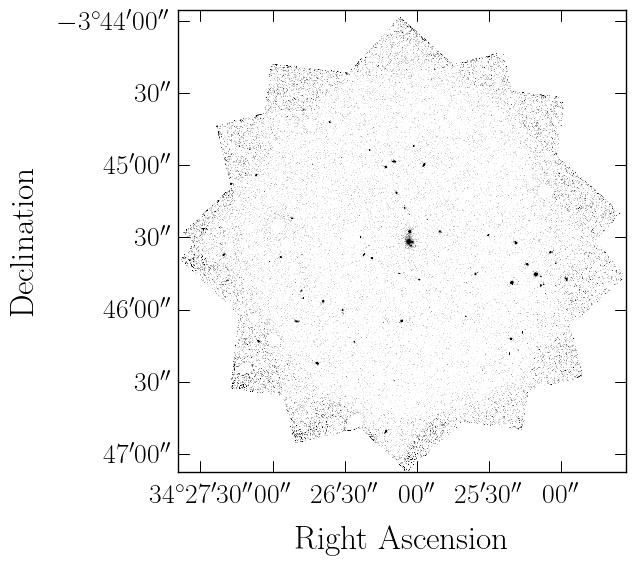

In [127]:
xlssc_rem_plot = np.multiply(fits.open(fits_path)[0].data, nomem_mask)
ax1=plt.subplot(projection=xlssc_wcs)
ax1.imshow(xlssc_rem_plot,vmin=0.004, vmax =0.05,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
ax1.set_xlim(600,3700)
ax1.set_ylim(3800,600)
ax1.grid(False)
ax1.invert_yaxis()

# converts the x-axis to degrees and works with the ticks:
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('Right Ascension')
lat.set_axislabel('Declination')
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(number=6)
lat.set_ticks(number=7)

# increases figure size:
ff = plt.gcf()
ff.set_size_inches(8,6)


#ax1.invert_yaxis()
    
plt.show()

In [21]:
np.shape(xray_image), np.shape(xlssc_image)

region_xray_image = xray_image[int(min_xray[1])+1:int(max_xray[1])+1, int(min_xray[0])+1:int(max_xray[0])+1]


print((min_xray), max_xray)

(array(375.53313127), array(389.06801862)) (array(452.33095569), array(463.47030541))


In [22]:
from skimage import io, transform 

np.shape(region_xray_image)


(74, 77)

In [29]:
res_xlssc_image = cv2.resize(xlssc_rem_plot, dsize=(900, 900), interpolation=cv2.INTER_CUBIC)
res_xray_image = cv2.resize(xray_image, dsize=(4312,4313), interpolation=cv2.INTER_NEAREST)

con_region_xray_image = astro_convolve(region_xray_image, gauss5_kernel)

res_region_xray_image = transform.resize(region_xray_image, (4313,4312), mode='constant')#, interpolation=cv2.INTER_NEAREST)

con_res_region_xray_image =transform.resize(region_xray_image, (4313,4312), mode='constant')
np.shape(res_region_xray_image)
#im1,im2 = FITS_tools.match_fits(xray_image,xlssc_rem_plot)


(4313, 4312)

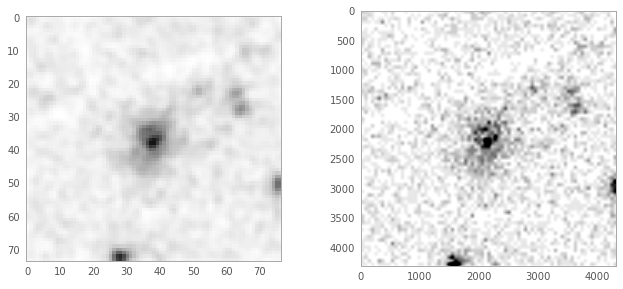

In [30]:
warnings.filterwarnings('ignore')

# plots the figure:
width=10
height=10
ff, (ax1,ax2) = plt.subplots(1,2)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=5.0)
ax1=plt.subplot(1,2,1)#,projection=xlssc_wcs)
ax1.imshow(con_region_xray_image,vmin=0.0040,vmax=10,cmap='gray_r', interpolation='none')

ax2=plt.subplot(1,2,2)#,projection=xray_wcs)
ax2.imshow(res_region_xray_image,vmin=0.0040,vmax=10,cmap='gray_r', interpolation='none')
# restricts image to just range of interest:
#ax2.set_xlim(min_xray[0], max_xray[0])
#ax2.set_ylim(min_xray[1], max_xray[1])
#ax1.set_xlim(min_xray[0], max_xray[0])
#ax1.set_ylim(min_xray[1], max_xray[1])
#ax1.set_xlim(min_extract[0],max_extract[0])
#ax1.set_ylim(min_extract[1],max_extract[1])

#ax1.set_ylim(ymin,ymax)
#ax1.set_title("XLSSC122 Image")
ax1.grid(False)
ax2.grid(False)
ax2.invert_yaxis()
ax1.invert_yaxis()
#converts the x-axis to degrees and works with the ticks:
# lon = ax1.coords[0]
# lat = ax1.coords[1]
# lon.set_axislabel('Right Ascension')
# lat.set_axislabel('Declination')
# lon.set_major_formatter('dd:mm:ss')
# lat.set_major_formatter('dd:mm:ss')
# lon.set_ticks(number=6)
# lat.set_ticks(number=7)
# lon = ax2.coords[0]
# lat = ax2.coords[1]
# lon.set_axislabel('Right Ascension')
# lat.set_axislabel('Declination')
# lon.set_major_formatter('dd:mm:ss')
# lat.set_major_formatter('dd:mm:ss')
# lon.set_ticks(number=6)
# lat.set_ticks(number=7)

ax1.invert_yaxis()
ax2.invert_yaxis()

plt.show()

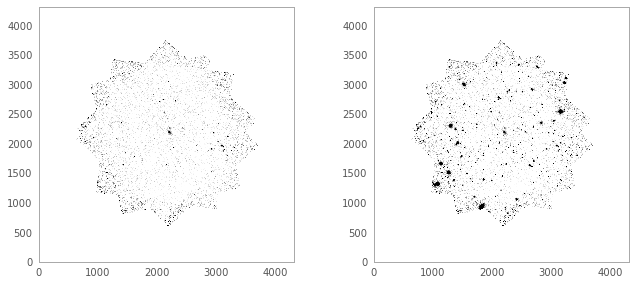

In [31]:
# plots the figure:
width=10
height=10
ff, (ax1,ax2) = plt.subplots(1,2)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=5.0)
ax1=plt.subplot(1,2,1)#,projection=xlssc_wcs)
ax1.imshow(xlssc_rem_plot,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')

ax2=plt.subplot(1,2,2)#,projection=xray_wcs)
ax2.imshow(xlssc_image,vmin=0.0040,vmax=0.05,cmap='gray_r', interpolation='none')

ax1.grid(False)
ax2.grid(False)


ax1.invert_yaxis()
ax2.invert_yaxis()

plt.show()

In [32]:
coeff_r_xlssc = np.corrcoef(xlssc_image.flat, res_region_xray_image.flat)
coeff_r_member = np.corrcoef(xlssc_rem_plot.flat, res_region_xray_image.flat)

print(coeff_r_xlssc[0,1], coeff_r_member[0,1])

0.0009449902939086534 -0.0018092706181798304


In [ ]:
# This next section outlines the first correlaation technique undertaken by the project
# we begin by first recompiling the needed data for this section:





array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)